# ANCOVA for pre/post treatment nonequivalent group designs

<div class="alert alert-warning">

Warning

This is a preliminary example based on synthetic data. It will hopefully soon be updated with data from a real study.

</div>

In [1]:
import causalpy as cp
import arviz as az

In [2]:
%load_ext autoreload
%autoreload 2
# %config InlineBackend.figure_format = 'svg'

## Generate synthetic data

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

N = 200


pre_treatment_means = np.array([10, 12])
treatment_effect = 2

group = np.random.choice(2, size=N)
pre = np.random.normal(loc=pre_treatment_means[group])
post = pre + treatment_effect * group + np.random.normal(size=N) * 0.4
df = pd.DataFrame({"group": group, "pre": pre, "post": post})
df.head()

,group,pre,post
0,1,10.629625,13.085239
1,0,9.788377,8.917721
2,0,10.486029,10.482804
3,1,12.537950,14.618826
4,0,9.256069,8.786750


/Users/benjamv/opt/mambaforge/envs/CausalPy/lib/python3.10/site-packages/seaborn/axisgrid.py:208: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  self._figure.subplots_adjust(right=right)


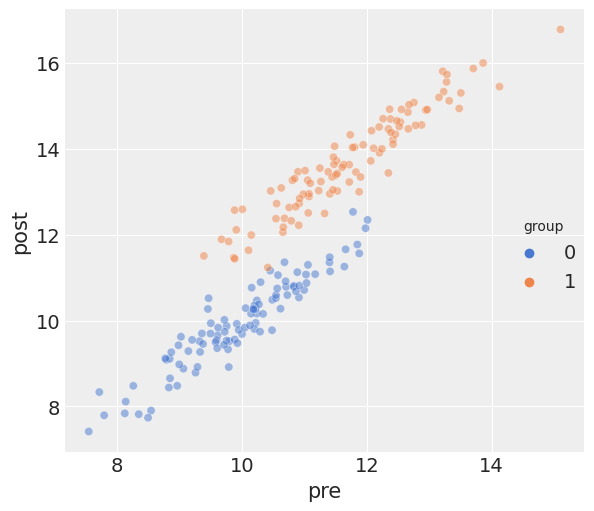

In [4]:
sns.relplot(x="pre", y="post", hue="group", alpha=0.5, palette="muted", data=df)

## Run the analysis

In [5]:
result = cp.pymc_experiments.PrePostNEGD(
    df,
    formula="post ~ 1 + C(group) + pre",
    group_variable_name="group",
    prediction_model=cp.pymc_models.LinearRegression(),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]


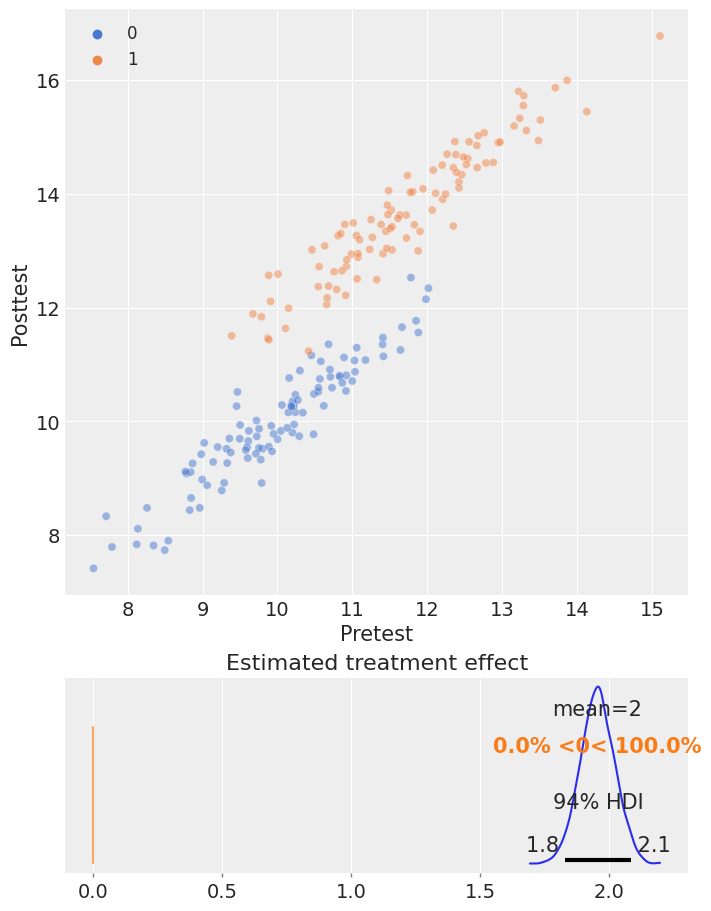

In [6]:
fig, ax = result.plot()

In [7]:
result.summary()

NotImplementedError: 